In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from fpex0 import fpex0
from fpex0.example.exampleSetup import exampleSetup, importExampleMeasurements
from fpex0 import setup

In [2]:
# GRIDS (manually)

tf = 20#0.5

# GRID0, default grid
N1 = 1000
grid0 = np.linspace( 60, 160, N1+1)
uni0 = True

# GRID1, h=0.1, 200 steps at h=0.025
N1 = 640
N2 = 200
N3 = 160
region1 = np.linspace( 60, 135, N1+1)
region2 = np.linspace(135, 140, N2+1)
region3 = np.linspace(140, 160, N3+1)
grid1   = np.concatenate((region1, region2[1:-1], region3))
uni1 = False
    
# GRID2, h=0.1, few steps at h=0.025 in steep region
N1 = 742
N2 = 10
N3 = 248
region1 = np.linspace( 60, 135, N1+1)
region2 = np.linspace(135, 135.25, N2+1)
region3 = np.linspace(135.25, 160, N3+1)
grid2   = np.concatenate((region1, region2[1:-1], region3))
uni2 = False

# GRID3, two steps at h=0.05, else h=0.1
N1 = 764
N2 = 2
N3 = 235
region1 = np.linspace( 60, 136.4, N1+1)
region2 = np.linspace(136.4, 136.5, N2+1)
region3 = np.linspace(136.5, 160, N3+1)
grid3   = np.concatenate((region1, region2[1:-1], region3))
uni3 = False

# GRID4, uniform stepsize h=0.05
N1 = 2000
grid4 = np.linspace( 60, 160, N1+1)
uni4 = True

# GRID6, uniform stepsize h=0.025
N1 = 500#4000
grid6 = np.linspace( 60, 160, N1+1)
uni6  = True

In [3]:
def tol_grid(Grid, distr, h, hmin, ytol):
    """
    h-refinement adaption.

    DEV/NOTE: Consider moving this to the Grid class later.

    ## Takes
    **Grid**:  Grid instance to edit

    **distr**:  
    Distribution for which the grid should be constructed; ytol is checked on this one.
    
    **h**:  
    Default step size. Chosen when it satisfies ytol.

    **hmin**:  
    Stepsize not to fall below.

    **ytol**:  
    Tolerance for difference in y.  
    At every grid point x_i should be satisfied y0(x_i+1) - y0(x_i) < ytol for the initial
    distribution y0, except such a step would undershoot hmin.

    ## Returns
    Returns a grid satisfying the given tolerances.  

    ### Comments  
    The number of grid points is not optimized. Also ytol is not checked at for the very last two steps, a shallow distribution is expected here.
    """

    # boundaries and help variables
    # NOTE: they should be named x0, xf
    x0, xf = Grid.gridT[[0,-1]]
    points = []
    x = x0

    # construct
    while x + 2*h < xf:
        step = h
        # step too big?
        while abs(distr(x+step) - distr(x)) > ytol:
            step *= 0.80
        
        step = max([step, hmin])
        points.append(x+step)
        x += step

    # last step individually to evade small last step
    # TODO: check ytol here too
    del_x = xf - x
    step = del_x/2
    points.append(x + step)
    points.append(xf)

    # update grid
    gridTdot = Grid.gridTdot
    tolGrid = setup.Grid(np.array(points), gridTdot, uniform=False)

    return tolGrid


def process_sim(sim, grid):
    data = {}
    if sim[0].success:
        sol = sim[0]
        data["duration"] = sim[1]
        data["y_cont"] = sol.sol
        data["t"] = sol.t
        data["y"] = sol.y
        data["steps"] = [sol.t[i+1] - sol.t[i] for i in range( len(sol.t)-1 )]
        data["fun_evals"] = sol.nfev
        data["grid"] = grid
    return data


def visualize_result(data):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
    
    # simulation: initial distribution
    init_distr = data["y_cont"](0)
    grid = data["grid"]
    # " plt1, = " to unpack a one-element tuple
    plt1, = ax1.plot(grid, init_distr, label="y(0)")
    ax1.legend()

    # TODO: Plot points instead of lines for integration steps!
    # time steps
    time = data["t"]
    steps = data["steps"]
    ax2.set_yscale("log")
    ax2.grid(True)
    plt2, = ax2.plot(time[:len(steps)], steps, label="Integration steps")
    ax2.legend()

    # time steps, zoomed in
    time_zoomed = np.extract(time <= 0.1, time)
    ax4.set_yscale("log")
    ax4.grid(True)
    plt4, = ax4.plot(time_zoomed, steps[:len(time_zoomed)], label="Integration steps")
    ax4.legend()

    # delta y
    deriv = [data["y"][i+1][0] - data["y"][i][0] for i in range( len(data["y"])-1 )]
    # ax3.set_yscale("log")
    plt3, = ax3.plot(grid[:len(deriv)], deriv, label="Delta y")
    ax3.legend()

    # simulation: animated
    sim, = ax5.plot(grid, data["y_cont"](tf), label=f"y({tf})")
    ax5.legend()

    # histogram, steps
    plt6 = ax6.hist(time, bins=20, edgecolor="black", label="Steps by interval")[0]
    ax6.grid(True)
    ax6.legend()

    # nframes = 60
    # ani_interval = 30
    # # anim_data = data["y_cont"](np.linspace(0,20, nframes))
    # def update(frame):
    #     x = grid
    #     y = data["y_cont"](20*frame/nframes)
    #     sim.set_data(x, y)
    #     return plt1, plt2, plt3, plt4, sim, plt6
    # 
    # ani = animation.FuncAnimation(fig, update, frames=nframes, interval=ani_interval)

    plt.show()
    # print(ani)

In [8]:
# SETUP

# configuration
FPEX0setup = exampleSetup('RK45')
print("Setting integration options.")
FPEX0setup.Integration.options["rtol"] = 1e-8
FPEX0setup.Integration.options["atol"] = 1e-14

# parameters
p0 = FPEX0setup.Parameters.p0
p1 = None # not collected
p2 = np.array([
    -0.8327084337935599,
    0.18970680548803662,
    1.3939484880107784,
    1.5812396369211503,
    2.446416668777252,
    26.85895074827626,
    132.6741069929283,
    7.7561076606807875,
    0.16500780763095269])
p3 = np.array([
-1.5065826449018027,
0.24712036078023447,
0.3594447970418686,
6.015166104841798,
2.5331420475991253,
25.74788719247742,
131.0379803572426,
6.39688701998876,
0.2396260734115967
])
p4 = np.array([
-1.5643394981488346,
0.22332252524996352,
0.1953200303475795,
9.684353586553787,
2.6051421643449273,
34.96256954527735,
131.27560828987936,
3.9627631160051564,
0.2451883915700899
])
pf = np.array([-0.9555,  0.03284, 0.2862, 3.4171, 2.5246, 43.0456, 131.8116, 3.5925, 0.1893])
pf2 = np.array([-1,  0.0, 0.1, 0.0, 2, 40, 135, 15, 0.1])
params = [p0, None, p2, p3, p4, pf, pf2]
pvec = params[2]
# pn corresponds to iteration n in the example fit
p_FPdrift     = FPEX0setup.Parameters.extract_p_FPdrift(pvec)
p_FPdiffusion = FPEX0setup.Parameters.extract_p_FPdiffusion(pvec)
p_IC          = FPEX0setup.Parameters.extract_p_iniDist(pvec)

# grid5, adaptive
FS0     = lambda x: FPEX0setup.IniDistFcn(np.array([x]), p_IC)
hmin = 0.05
ytol = 2
grid5 = tol_grid(FPEX0setup.Grid, distr=FS0, h=0.1, hmin=hmin, ytol=ytol).gridT
uni5 = False

# select grid
gridT = grid0
uni   = uni0

gridTdot = FPEX0setup.Grid.gridTdot
newGrid = setup.Grid(gridT, gridTdot, uniform=uni)
FPEX0setup.Grid = newGrid

# print(f"Spatial grid: hmin is {FPEX0setup.Grid.h.min()}.")


Setting integration options.


/home/mstrik/software/fpex0-project/py3.10-env/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


Simulate: 2.933s
RHS evals: 25976
Success: True


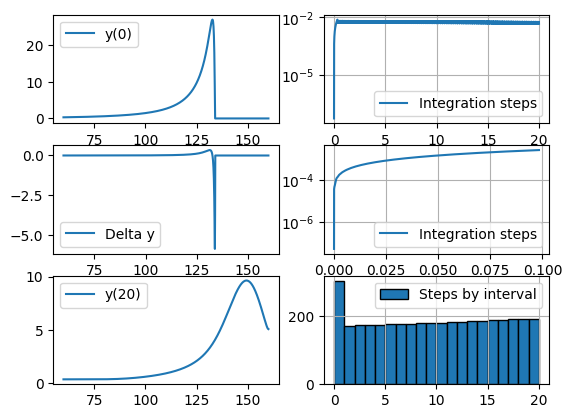

In [9]:
# SIMULATE (LSQ Iteration 0)

# integration interval, only beginning for now
FPEX0setup.Grid.gridTdot = np.array([0,  tf])
simulation = fpex0.simulate(FPEX0setup, pvec)
print(f"RHS evals: {simulation.nfev}")
print(f"Success: {simulation.success}")

# process and visualize output
sim_data = [simulation, 0.0]
data = process_sim(sim_data, gridT)
visualize_result(data)

In [6]:
y = data["y_cont"]
n_grid = 1000
k_grid = np.array([764, 765])
h = 100/n_grid
x = 60 + k_grid*h

print(y(0)[k_grid])
print(x)


[0. 0.]
[136.4 136.5]


In [7]:
print(len(gridT))

1001
